This document aims to describe challanges we faced when applying techniques from [this library](https://github.com/guillaumegenthial/im2latex) to achieve the image-to-latex transformation.

In [1]:
from demo import img2latex
from model.img2seq import Img2SeqModel
from model.utils.general import Config, run
from model.utils.text import Vocab
from IPython.display import Image, display, Math, Latex
from wand.image import Image as WImage
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
%load_ext autoreload
%autoreload 2

In [2]:
dir_output = "results/full/"
config_vocab = Config(dir_output + "vocab.json")
config_model = Config(dir_output + "model.json")
vocab = Vocab(config_vocab)

model = Img2SeqModel(config_model, dir_output, vocab)
model.build_pred()
model.restore_session(dir_output + "model.weights/")

Building model...
- done.
Reloading the latest trained model...


INFO:tensorflow:Restoring parameters from results/full/model.weights/


Restoring parameters from results/full/model.weights/


In [3]:
import json

def predict(src, ratio, img_augment=None):
    result, img, output_path = img2latex(model, src, ratio, img_augment=img_augment)
    print(src)
    print('Image:')
    display(Image(output_path))
    print("Recognized latex:")
    print(result)
    print("\nCompilation from recognized latex:")
    display(Math(result))

# Issues encountered in the existing framework

## Very sensitive to the image size

The example below demonstrates that the model works well on an image from the test set. However, it fails on the exact same image but slightly different size.

Pixel Dimensions: (50, 320, 3)
data/images_test/2.png
Image:


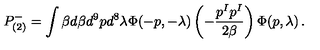

Recognized latex:
P _ { ( 2 ) } ^ { - } = \int \beta d \beta d ^ { 9 } p d ^ { 8 } \lambda \Phi ( - p , - \lambda ) \left( - \frac { p ^ { I } p ^ { I } } { 2 \beta } \right) \Phi ( p , \lambda ) \, .

Compilation from recognized latex:


<IPython.core.display.Math object>

In [4]:
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=None)

The above image uses the size provided by the framework. If the size of the image is slightly altered, the result changes and becomes uncompilable.

Pixel Dimensions: (47, 304, 3)
data/images_test/2.png
Image:


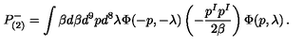

Recognized latex:
P _ { ( 2 ) } ^ { - } = \int \beta d \beta { ^ { 3 } p d ^ { 8 } \lambda \Phi ( - p , - \lambda ) \left( - \frac { p ^ { I } p ^ { I } } { 2 \dot { \beta } } \right) \Phi ( p , \lambda ) \, .

Compilation from recognized latex:


<IPython.core.display.Math object>

In [5]:
predict('data/images_test/%s.png'%'2', ratio=1.05, img_augment=None)

The example below increases the image size by 5% and the framework started to generate incorrect latex code as well.

Pixel Dimensions: (52, 336, 3)
data/images_test/2.png
Image:


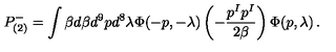

Recognized latex:
P _ { ( 2 ) } ^ { - } = \int \beta d { \beta } { \beta ^ { 4 } } p d ^ { ( - p , - \lambda ) \left( - \frac { p ^ { I } p ^ { I } } { 2 \beta } \right) \Phi ( p , \lambda ) \, .

Compilation from recognized latex:


<IPython.core.display.Math object>

In [6]:
predict('data/images_test/%s.png'%'2', ratio=0.95, img_augment=None)

If there is a big change of size in the test image, the result changes significantly

Pixel Dimensions: (38, 246, 3)
data/images_test/2.png
Image:


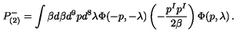

Recognized latex:
\stackrel { { P _ { } _ { [ } \hat { \beta } d { \hat { \beta } d { d } d ^ { \prime } } } } { } } \lambda \Phi ( - p , - \lambda ) \left( - \frac { p ^ { \prime } p ^ { \prime } } { 2 j } } \right) _ { \Phi ( p , \lambda ) } .

Compilation from recognized latex:


<IPython.core.display.Math object>

In [7]:
predict('data/images_test/%s.png'%'2', ratio=1.3, img_augment=None)

## Sensitive to small noise

From the same image used in the previous example as shown below

In [ ]:
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=None)

Pixel Dimensions: (50, 320, 3)


The prediction result changes if there is a little noise added.

In [ ]:
f = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0.45))
    ])
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=f)

## A short survey on the prediction results from image that is in the test set but has been modified by simple augmentation techniques.

### MotionBlur

In [ ]:
f = iaa.Sequential([
        iaa.MotionBlur(k=3)
    ])
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=f)

### Multiply

In [ ]:
f = iaa.Sequential([
        iaa.Multiply((0.5, 3), per_channel=1)
    ])
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=f)

### Dropout

In [ ]:
f = iaa.Sequential([
        iaa.Dropout(p=0.005)
    ])
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=f)

### Pad

In [ ]:
from imgaug import augmenters as iaa
import imgaug as ia
f = iaa.Sequential([
        iaa.Pad((0,8,0,0))
    ])
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=f)

### Invert

In [ ]:
f = iaa.Sequential([
        iaa.Invert(1, per_channel=True)
    ])
predict('data/images_test/%s.png'%'2', ratio=1, img_augment=f)